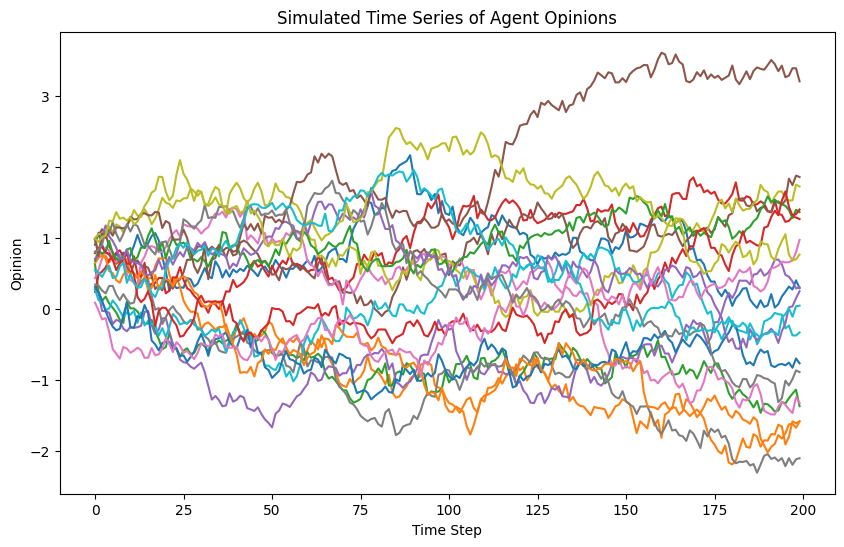

True parameter: 0.2
Inferred parameter: 0.010149200072081302
Final log-likelihood: -3176.9991153470082


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing

class OpinionDynamics:
    def __init__(self, n_agents, n_steps, true_param, noise_sigma, n_samples=100):
        self.n_agents = n_agents
        self.n_steps = n_steps
        self.true_param = true_param
        self.noise_sigma = noise_sigma
        self.n_samples = n_samples
        self.X = np.random.rand(n_agents)  # Initial opinions
        self.opinion_history = []

    def simulate(self):
        """ Simulate agent opinion dynamics over time. """
        self.opinion_history = []
        for t in range(self.n_steps):
            self.opinion_history.append(self.X.copy())
            for i in range(self.n_agents):
                # Pick a random agent j from neighbors
                j = np.random.randint(0, self.n_agents)
                kernel_value = self.kernel(self.X[i], self.X[j], self.true_param)
                delta_i = np.random.normal(loc=kernel_value * (self.X[j] - self.X[i]), scale=self.noise_sigma)
                self.X[i] += delta_i

    def kernel(self, X_i, X_j, param):
        """ Exact step-function kernel. """
        return 1 if abs(X_j - X_i) < param else 0

    def log_likelihood(self, param, opinion_history):
        """ Approximate the log-likelihood via Monte Carlo simulation. """
        log_likelihood = 0
        for _ in range(self.n_samples):  # Perform multiple Monte Carlo samples
            total_log_likelihood = 0
            for t in range(1, len(opinion_history)):
                for i in range(self.n_agents):
                    X_t = opinion_history[t][i]
                    X_t_1 = opinion_history[t-1][i]
                    # Use the exact kernel based on the parameter `param`
                    kernel_value = self.kernel(X_t_1, X_t, param)
                    # Gaussian likelihood for opinion updates
                    total_log_likelihood += -0.5 * np.log(2 * np.pi * self.noise_sigma ** 2) - 0.5 * ((X_t - X_t_1 - kernel_value * (X_t_1 - X_t)) ** 2) / self.noise_sigma ** 2
            log_likelihood += total_log_likelihood
        return -log_likelihood / self.n_samples  # Negative log-likelihood for minimization

    def fit(self, opinion_history):
        """ Use Simulated Annealing to fit the kernel parameter. """
        # Use Simulated Annealing (SA) to find the best parameter
        def objective(param):
            return self.log_likelihood(param, opinion_history)

        # Simulated Annealing optimization
        bounds = [(0.01, 1.0)]  # Parameter range [0.01, 1.0]
        result = dual_annealing(objective, bounds)

        return result.x[0], result.fun  # Return inferred parameter and final log-likelihood

    def plot_time_series(self):
        """ Plot the simulated time series of agent opinions. """
        plt.figure(figsize=(10, 6))
        for i in range(self.n_agents):
            plt.plot(range(self.n_steps), np.array(self.opinion_history)[:, i], label=f'Agent {i+1}')

        plt.xlabel('Time Step')
        plt.ylabel('Opinion')
        plt.title('Simulated Time Series of Agent Opinions')
        plt.show()


# Simulate the system with true parameters
true_param = 0.2
n_agents = 20  # Increased number of agents
n_steps = 200  # Increased number of time steps
noise_sigma = 0.1
model = OpinionDynamics(n_agents, n_steps, true_param, noise_sigma)

# Simulate agent opinions
model.simulate()

# Plot the simulated time series of opinions
model.plot_time_series()

# Perform Simulated Annealing to infer the kernel parameter
inferred_param, final_log_likelihood = model.fit(model.opinion_history)

# Print the inferred parameter and the log-likelihood value
print(f"True parameter: {true_param}")
print(f"Inferred parameter: {inferred_param}")
print(f"Final log-likelihood: {final_log_likelihood}")


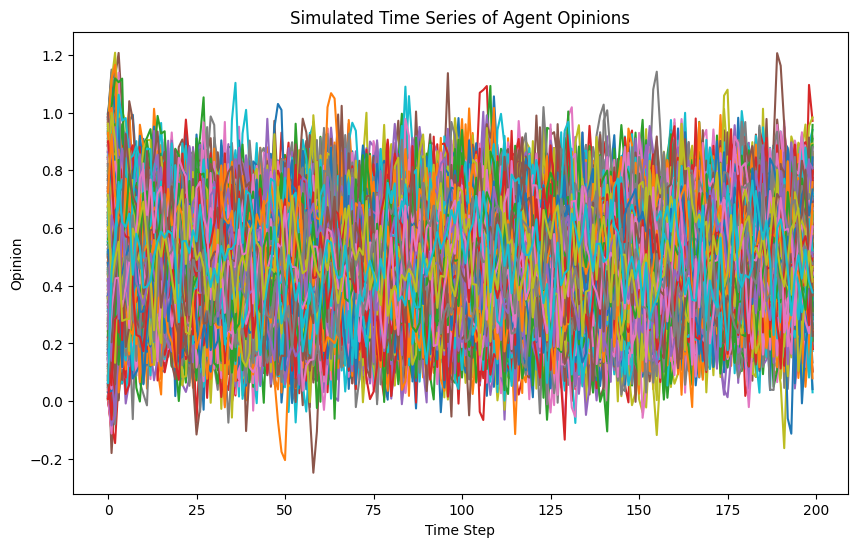

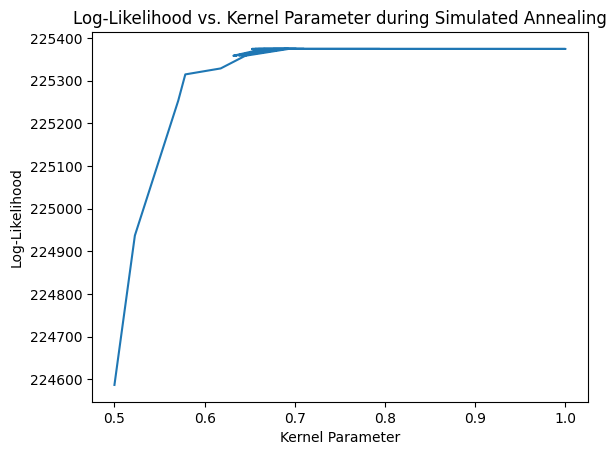

True parameter: 0.7
Inferred parameter: 0.6598018314866375
Maximum log-likelihood: 225374.25829659


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class OpinionDynamics:
    def __init__(self, n_agents, n_steps, true_param, lambda_true, noise_sigma):
        self.n_agents = n_agents
        self.n_steps = n_steps
        self.true_param = true_param  # True kernel parameter
        self.lambda_true = lambda_true  # True lambda for the model
        self.noise_sigma = noise_sigma
        self.X = np.random.rand(n_agents)  # Initial opinions
        self.opinion_history = []

    def simulate(self):
        """ Simulate agent opinion dynamics over time. """
        self.opinion_history = []
        for t in range(self.n_steps):
            self.opinion_history.append(self.X.copy())
            for i in range(self.n_agents):
                # Pick a random agent j from neighbors (for simplicity, we choose randomly)
                j = np.random.randint(0, self.n_agents)
                kernel_value = self.kernel(self.X[i], self.X[j], self.true_param)  # Use true_param here
                delta_i = np.random.normal(loc=self.lambda_true * kernel_value * (self.X[j] - self.X[i]),
                                           scale=self.noise_sigma)
                self.X[i] += delta_i

    def kernel(self, X_i, X_j, param):
        """ Non-smooth step-function kernel. """
        return 1 if abs(X_j - X_i) < param else 0

    def log_likelihood(self, param):
        """ Log-likelihood calculation for the kernel parameter. """
        log_likelihood = 0
        for t in range(1, len(self.opinion_history)):
            for i in range(self.n_agents):
                X_t = self.opinion_history[t][i]
                X_t_1 = self.opinion_history[t-1][i]
                kernel_value = self.kernel(X_t_1, X_t, param)  # Use param here

                # The update should follow a Gaussian distribution as defined in the model
                predicted_delta = self.lambda_true * kernel_value * (X_t - X_t_1)

                # Log-likelihood computation based on Gaussian distribution
                log_likelihood += -0.5 * np.log(2 * np.pi * self.noise_sigma ** 2) - 0.5 * ((X_t - X_t_1 - predicted_delta) ** 2) / self.noise_sigma ** 2

        return log_likelihood

    def simulated_annealing(self, initial_param, temperature, cooling_rate, n_iterations):
        """ Simulated Annealing to optimize the kernel parameter. """
        current_param = initial_param
        current_log_likelihood = self.log_likelihood(current_param)

        best_param = current_param
        best_log_likelihood = current_log_likelihood

        log_likelihoods = [current_log_likelihood]
        params = [current_param]

        for iteration in range(n_iterations):
            # Perturb the current parameter within a small range
            new_param = current_param + np.random.uniform(-0.05, 0.05)  # Perturbation
            new_param = np.clip(new_param, 0.1, 1.0)  # Make sure the new parameter stays within bounds

            new_log_likelihood = self.log_likelihood(new_param)

            # Acceptance probability (Metropolis criterion)
            if new_log_likelihood > current_log_likelihood or np.random.rand() < np.exp((new_log_likelihood - current_log_likelihood) / temperature):
                current_param = new_param
                current_log_likelihood = new_log_likelihood

            # Update best parameter if necessary
            if current_log_likelihood > best_log_likelihood:
                best_param = current_param
                best_log_likelihood = current_log_likelihood

            # Store values for later plotting
            log_likelihoods.append(current_log_likelihood)
            params.append(current_param)

            # Decrease temperature
            temperature *= cooling_rate

        # Plot the log-likelihood over time
        plt.plot(params, log_likelihoods, label='Log-Likelihood vs. Parameter (Simulated Annealing)')
        plt.xlabel('Kernel Parameter')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood vs. Kernel Parameter during Simulated Annealing')
        plt.show()

        return best_param, best_log_likelihood

    def plot_time_series(self):
        """ Plot the simulated time series of agent opinions. """
        plt.figure(figsize=(10, 6))
        for i in range(self.n_agents):
            plt.plot(range(self.n_steps), np.array(self.opinion_history)[:, i], label=f'Agent {i+1}')

        plt.xlabel('Time Step')
        plt.ylabel('Opinion')
        plt.title('Simulated Time Series of Agent Opinions')
        plt.show()


# Simulate the system with true parameters
true_param = 0.7  # True kernel parameter for simulation
lambda_true = 0.5  # True lambda for the model (susceptibility to influence)
n_agents = 10**3  # Number of agents
n_steps = 200  # Number of time steps
noise_sigma = 0.1  # Noise standard deviation
model = OpinionDynamics(n_agents, n_steps, true_param, lambda_true, noise_sigma)

# Simulate agent opinions
model.simulate()

# Plot the simulated time series of opinions
model.plot_time_series()

# Use Simulated Annealing to infer the kernel parameter (param)
initial_param = 0.5  # Starting point for simulated annealing
temperature = 10.0  # Initial temperature (controls randomness)
cooling_rate = 0.99  # Cooling rate (how quickly temperature decreases)
n_iterations = 1000  # Number of iterations for simulated annealing

inferred_param, final_log_likelihood = model.simulated_annealing(initial_param, temperature, cooling_rate, n_iterations)

# Print the inferred parameter and the log-likelihood value
print(f"True parameter: {true_param}")
print(f"Inferred parameter: {inferred_param}")
print(f"Maximum log-likelihood: {final_log_likelihood}")


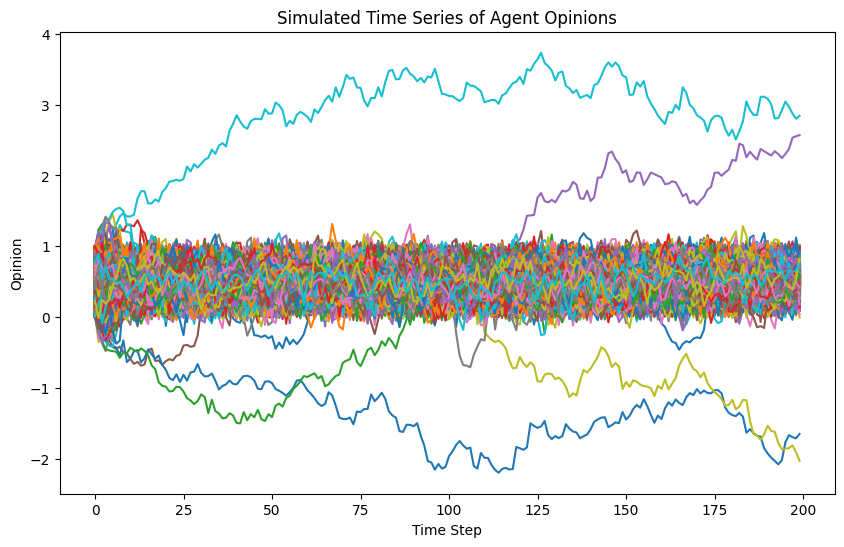

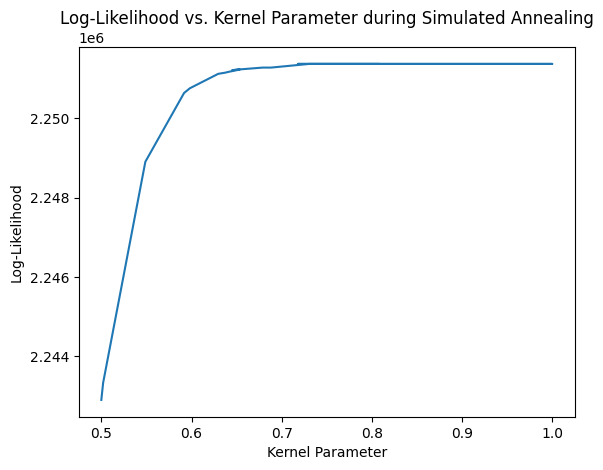

True parameter: 0.7
Inferred parameter: 0.7305283784114284
Maximum log-likelihood: 2251367.530502641


In [3]:
import numpy as np
import matplotlib.pyplot as plt

class OpinionDynamics:
    def __init__(self, n_agents, n_steps, true_param, lambda_true, noise_sigma):
        self.n_agents = n_agents
        self.n_steps = n_steps
        self.true_param = true_param  # True kernel parameter
        self.lambda_true = lambda_true  # True lambda for the model
        self.noise_sigma = noise_sigma
        self.X = np.random.rand(n_agents)  # Initial opinions
        self.opinion_history = []

    def simulate(self):
        """ Simulate agent opinion dynamics over time. """
        self.opinion_history = []
        for t in range(self.n_steps):
            self.opinion_history.append(self.X.copy())
            for i in range(self.n_agents):
                # Pick a random agent j from neighbors (for simplicity, we choose randomly)
                j = np.random.randint(0, self.n_agents)
                kernel_value = self.kernel(self.X[i], self.X[j], self.true_param)  # Use true_param here
                delta_i = np.random.normal(loc=self.lambda_true * kernel_value * (self.X[j] - self.X[i]),
                                           scale=self.noise_sigma)
                self.X[i] += delta_i

    def kernel(self, X_i, X_j, param):
        """ Non-smooth step-function kernel. """
        return 1 if abs(X_j - X_i) < param else 0

    def log_likelihood(self, param):
        """ Log-likelihood calculation for the kernel parameter. """
        log_likelihood = 0
        for t in range(1, len(self.opinion_history)):
            for i in range(self.n_agents):
                X_t = self.opinion_history[t][i]
                X_t_1 = self.opinion_history[t-1][i]
                kernel_value = self.kernel(X_t_1, X_t, param)  # Use param here

                # The update should follow a Gaussian distribution as defined in the model
                predicted_delta = self.lambda_true * kernel_value * (X_t - X_t_1)

                # Log-likelihood computation based on Gaussian distribution
                log_likelihood += -0.5 * np.log(2 * np.pi * self.noise_sigma ** 2) - 0.5 * ((X_t - X_t_1 - predicted_delta) ** 2) / self.noise_sigma ** 2

        return log_likelihood

    def simulated_annealing(self, initial_param, temperature, cooling_rate, n_iterations):
        """ Simulated Annealing to optimize the kernel parameter. """
        current_param = initial_param
        current_log_likelihood = self.log_likelihood(current_param)

        best_param = current_param
        best_log_likelihood = current_log_likelihood

        log_likelihoods = [current_log_likelihood]
        params = [current_param]

        for iteration in range(n_iterations):
            # Perturb the current parameter within a small range
            new_param = current_param + np.random.uniform(-0.05, 0.05)  # Perturbation
            new_param = np.clip(new_param, 0.1, 1.0)  # Make sure the new parameter stays within bounds

            new_log_likelihood = self.log_likelihood(new_param)

            # Acceptance probability (Metropolis criterion)
            if new_log_likelihood > current_log_likelihood or np.random.rand() < np.exp((new_log_likelihood - current_log_likelihood) / temperature):
                current_param = new_param
                current_log_likelihood = new_log_likelihood

            # Update best parameter if necessary
            if current_log_likelihood > best_log_likelihood:
                best_param = current_param
                best_log_likelihood = current_log_likelihood

            # Store values for later plotting
            log_likelihoods.append(current_log_likelihood)
            params.append(current_param)

            # Decrease temperature
            temperature *= cooling_rate

        # Plot the log-likelihood over time
        plt.plot(params, log_likelihoods, label='Log-Likelihood vs. Parameter (Simulated Annealing)')
        plt.xlabel('Kernel Parameter')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood vs. Kernel Parameter during Simulated Annealing')
        plt.show()

        return best_param, best_log_likelihood

    def plot_time_series(self):
        """ Plot the simulated time series of agent opinions. """
        plt.figure(figsize=(10, 6))
        for i in range(self.n_agents):
            plt.plot(range(self.n_steps), np.array(self.opinion_history)[:, i], label=f'Agent {i+1}')

        plt.xlabel('Time Step')
        plt.ylabel('Opinion')
        plt.title('Simulated Time Series of Agent Opinions')
        plt.show()


# Simulate the system with true parameters
true_param = 0.7  # True kernel parameter for simulation
lambda_true = 0.5  # True lambda for the model (susceptibility to influence)
n_agents = 10**4  # Number of agents
n_steps = 200  # Number of time steps
noise_sigma = 0.1  # Noise standard deviation
model = OpinionDynamics(n_agents, n_steps, true_param, lambda_true, noise_sigma)

# Simulate agent opinions
model.simulate()

# Plot the simulated time series of opinions
model.plot_time_series()

# Use Simulated Annealing to infer the kernel parameter (param)
initial_param = 0.5  # Starting point for simulated annealing
temperature = 10.0  # Initial temperature (controls randomness)
cooling_rate = 0.99  # Cooling rate (how quickly temperature decreases)
n_iterations = 1000  # Number of iterations for simulated annealing

inferred_param, final_log_likelihood = model.simulated_annealing(initial_param, temperature, cooling_rate, n_iterations)

# Print the inferred parameter and the log-likelihood value
print(f"True parameter: {true_param}")
print(f"Inferred parameter: {inferred_param}")
print(f"Maximum log-likelihood: {final_log_likelihood}")
